# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

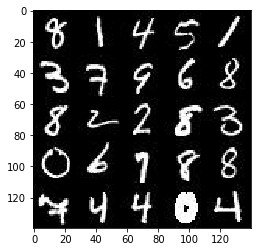

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

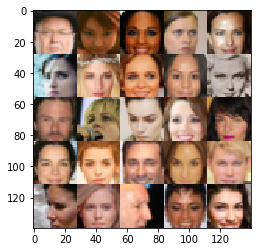

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels],
                                name='input_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/riei1/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/riei1/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/riei1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/riei1/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/riei1/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/riei1/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xin_channel_dim
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [40]:
tf.reset_default_graph()

In [43]:
import pickle as pkl

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    show_n_images = 25
    print_every = 10
    show_every = 100
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]

    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    saver = tf.train.Saver()
    samples, losses = [], []
    steps = 0    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, input_z, image_channels, data_image_mode)

        saver.save(sess, './checkpoints/' + data_image_mode + '_generator.ckpt')

    with open(data_image_mode + '_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    with open(data_image_mode + '_losses.pkl', 'wb') as f:
        pkl.dump(losses, f)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2118... Generator Loss: 16.3635
Epoch 1/2... Discriminator Loss: 0.0386... Generator Loss: 3.5916
Epoch 1/2... Discriminator Loss: 2.5595... Generator Loss: 0.2098
Epoch 1/2... Discriminator Loss: 0.2014... Generator Loss: 13.3313
Epoch 1/2... Discriminator Loss: 0.0433... Generator Loss: 3.9851
Epoch 1/2... Discriminator Loss: 0.6537... Generator Loss: 1.7941
Epoch 1/2... Discriminator Loss: 2.6806... Generator Loss: 0.0955
Epoch 1/2... Discriminator Loss: 2.6737... Generator Loss: 0.1486
Epoch 1/2... Discriminator Loss: 0.5993... Generator Loss: 2.2101
Epoch 1/2... Discriminator Loss: 0.4741... Generator Loss: 1.5679


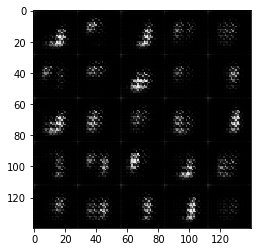

Epoch 1/2... Discriminator Loss: 0.5030... Generator Loss: 1.3310
Epoch 1/2... Discriminator Loss: 0.2804... Generator Loss: 2.8435
Epoch 1/2... Discriminator Loss: 3.3209... Generator Loss: 0.0664
Epoch 1/2... Discriminator Loss: 1.1475... Generator Loss: 0.6426
Epoch 1/2... Discriminator Loss: 0.3911... Generator Loss: 2.9954
Epoch 1/2... Discriminator Loss: 0.7906... Generator Loss: 4.6893
Epoch 1/2... Discriminator Loss: 0.2875... Generator Loss: 3.6358
Epoch 1/2... Discriminator Loss: 0.2261... Generator Loss: 2.1211
Epoch 1/2... Discriminator Loss: 0.1204... Generator Loss: 2.6346
Epoch 1/2... Discriminator Loss: 0.2309... Generator Loss: 2.0929


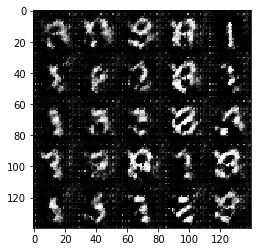

Epoch 1/2... Discriminator Loss: 0.1326... Generator Loss: 3.7234
Epoch 1/2... Discriminator Loss: 0.3620... Generator Loss: 1.9910
Epoch 1/2... Discriminator Loss: 0.1909... Generator Loss: 2.4467
Epoch 1/2... Discriminator Loss: 0.0680... Generator Loss: 3.8063
Epoch 1/2... Discriminator Loss: 4.1019... Generator Loss: 0.0282
Epoch 1/2... Discriminator Loss: 0.2681... Generator Loss: 1.8090
Epoch 1/2... Discriminator Loss: 0.2798... Generator Loss: 1.7807
Epoch 1/2... Discriminator Loss: 6.5201... Generator Loss: 12.7569
Epoch 1/2... Discriminator Loss: 0.5066... Generator Loss: 1.3938
Epoch 1/2... Discriminator Loss: 0.5688... Generator Loss: 5.3635


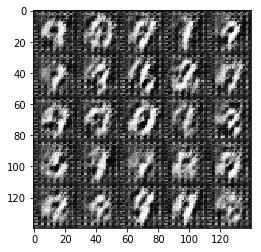

Epoch 1/2... Discriminator Loss: 0.0475... Generator Loss: 7.5428
Epoch 1/2... Discriminator Loss: 1.1431... Generator Loss: 0.5455
Epoch 1/2... Discriminator Loss: 1.2651... Generator Loss: 0.4952
Epoch 1/2... Discriminator Loss: 0.8402... Generator Loss: 4.7792
Epoch 1/2... Discriminator Loss: 0.5617... Generator Loss: 1.2977
Epoch 1/2... Discriminator Loss: 0.8235... Generator Loss: 3.4936
Epoch 1/2... Discriminator Loss: 0.7850... Generator Loss: 0.8389
Epoch 1/2... Discriminator Loss: 0.8049... Generator Loss: 0.7146
Epoch 1/2... Discriminator Loss: 0.2126... Generator Loss: 2.0462
Epoch 1/2... Discriminator Loss: 1.3496... Generator Loss: 5.9890


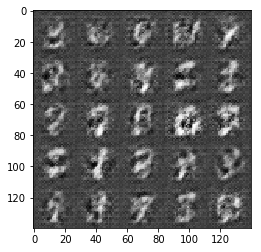

Epoch 1/2... Discriminator Loss: 0.0657... Generator Loss: 4.3405
Epoch 1/2... Discriminator Loss: 0.4586... Generator Loss: 2.6615
Epoch 1/2... Discriminator Loss: 0.3147... Generator Loss: 4.1176
Epoch 1/2... Discriminator Loss: 1.4715... Generator Loss: 0.3326
Epoch 1/2... Discriminator Loss: 1.3807... Generator Loss: 0.4101
Epoch 1/2... Discriminator Loss: 0.7224... Generator Loss: 0.8131
Epoch 1/2... Discriminator Loss: 0.5558... Generator Loss: 1.1687
Epoch 1/2... Discriminator Loss: 0.3731... Generator Loss: 1.4611
Epoch 1/2... Discriminator Loss: 0.6152... Generator Loss: 1.0097
Epoch 1/2... Discriminator Loss: 0.3755... Generator Loss: 1.6616


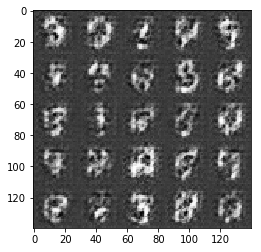

Epoch 1/2... Discriminator Loss: 0.7585... Generator Loss: 0.7980
Epoch 1/2... Discriminator Loss: 0.5092... Generator Loss: 1.5640
Epoch 1/2... Discriminator Loss: 0.4793... Generator Loss: 1.1269
Epoch 1/2... Discriminator Loss: 0.3539... Generator Loss: 1.4825
Epoch 1/2... Discriminator Loss: 0.2999... Generator Loss: 1.7169
Epoch 1/2... Discriminator Loss: 0.1069... Generator Loss: 3.0029
Epoch 1/2... Discriminator Loss: 0.2151... Generator Loss: 2.0819
Epoch 1/2... Discriminator Loss: 0.0710... Generator Loss: 3.5167
Epoch 1/2... Discriminator Loss: 0.0610... Generator Loss: 4.9438
Epoch 1/2... Discriminator Loss: 0.0892... Generator Loss: 3.1214


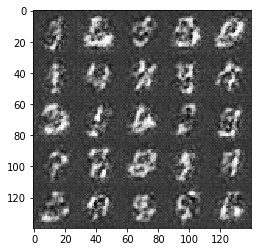

Epoch 1/2... Discriminator Loss: 5.7717... Generator Loss: 9.2465
Epoch 1/2... Discriminator Loss: 1.0780... Generator Loss: 0.5783
Epoch 1/2... Discriminator Loss: 0.9474... Generator Loss: 0.6594
Epoch 1/2... Discriminator Loss: 0.4357... Generator Loss: 1.4056
Epoch 1/2... Discriminator Loss: 0.2250... Generator Loss: 2.0581
Epoch 1/2... Discriminator Loss: 0.2925... Generator Loss: 1.6687
Epoch 1/2... Discriminator Loss: 0.0726... Generator Loss: 3.7023
Epoch 1/2... Discriminator Loss: 0.1878... Generator Loss: 2.1212
Epoch 1/2... Discriminator Loss: 0.1381... Generator Loss: 2.5457
Epoch 1/2... Discriminator Loss: 0.0262... Generator Loss: 4.0918


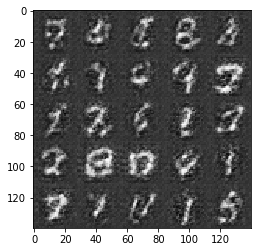

Epoch 1/2... Discriminator Loss: 0.7723... Generator Loss: 0.7730
Epoch 1/2... Discriminator Loss: 0.4244... Generator Loss: 1.3996
Epoch 1/2... Discriminator Loss: 0.2555... Generator Loss: 1.8447
Epoch 1/2... Discriminator Loss: 0.3763... Generator Loss: 1.3764
Epoch 1/2... Discriminator Loss: 0.0658... Generator Loss: 3.0659
Epoch 1/2... Discriminator Loss: 0.1271... Generator Loss: 2.4615
Epoch 1/2... Discriminator Loss: 0.0311... Generator Loss: 3.9703
Epoch 1/2... Discriminator Loss: 0.1115... Generator Loss: 2.6341
Epoch 1/2... Discriminator Loss: 0.0851... Generator Loss: 2.9028
Epoch 1/2... Discriminator Loss: 0.0851... Generator Loss: 5.6427


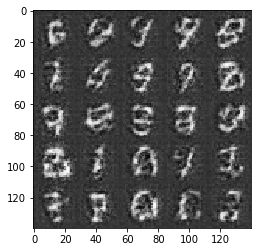

Epoch 1/2... Discriminator Loss: 0.1208... Generator Loss: 2.6591
Epoch 1/2... Discriminator Loss: 0.0346... Generator Loss: 3.9652
Epoch 1/2... Discriminator Loss: 0.0112... Generator Loss: 6.6320
Epoch 1/2... Discriminator Loss: 14.0417... Generator Loss: 16.0446
Epoch 1/2... Discriminator Loss: 1.2549... Generator Loss: 0.4425
Epoch 1/2... Discriminator Loss: 0.4328... Generator Loss: 1.3134
Epoch 1/2... Discriminator Loss: 0.3270... Generator Loss: 1.5050
Epoch 1/2... Discriminator Loss: 0.3152... Generator Loss: 1.4650
Epoch 1/2... Discriminator Loss: 0.0527... Generator Loss: 3.9683
Epoch 1/2... Discriminator Loss: 2.8399... Generator Loss: 0.0728


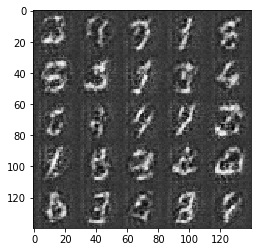

Epoch 1/2... Discriminator Loss: 1.0314... Generator Loss: 0.9993
Epoch 1/2... Discriminator Loss: 1.1080... Generator Loss: 0.5617
Epoch 1/2... Discriminator Loss: 1.3947... Generator Loss: 0.3600
Epoch 1/2... Discriminator Loss: 1.3308... Generator Loss: 0.4660
Epoch 1/2... Discriminator Loss: 2.1391... Generator Loss: 0.1542
Epoch 1/2... Discriminator Loss: 2.2761... Generator Loss: 4.3931
Epoch 1/2... Discriminator Loss: 0.6887... Generator Loss: 0.9291
Epoch 1/2... Discriminator Loss: 0.8793... Generator Loss: 0.6466
Epoch 1/2... Discriminator Loss: 1.2539... Generator Loss: 3.4931
Epoch 1/2... Discriminator Loss: 0.6223... Generator Loss: 0.9028


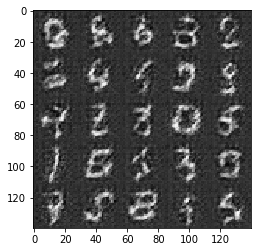

Epoch 1/2... Discriminator Loss: 0.3392... Generator Loss: 1.6947
Epoch 1/2... Discriminator Loss: 0.4734... Generator Loss: 1.1655
Epoch 1/2... Discriminator Loss: 0.1243... Generator Loss: 2.6650
Epoch 1/2... Discriminator Loss: 0.2496... Generator Loss: 1.7823
Epoch 1/2... Discriminator Loss: 0.0987... Generator Loss: 2.6101
Epoch 1/2... Discriminator Loss: 0.1792... Generator Loss: 2.0515
Epoch 1/2... Discriminator Loss: 0.1212... Generator Loss: 2.4724
Epoch 1/2... Discriminator Loss: 0.0602... Generator Loss: 3.5361
Epoch 1/2... Discriminator Loss: 0.3685... Generator Loss: 1.3922
Epoch 1/2... Discriminator Loss: 0.0546... Generator Loss: 3.4535


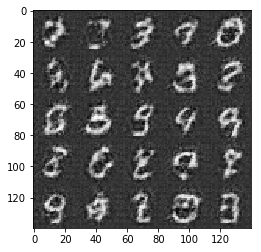

Epoch 1/2... Discriminator Loss: 0.0228... Generator Loss: 5.4867
Epoch 1/2... Discriminator Loss: 0.0164... Generator Loss: 5.1597
Epoch 1/2... Discriminator Loss: 0.1268... Generator Loss: 2.4473
Epoch 1/2... Discriminator Loss: 0.0259... Generator Loss: 5.7639
Epoch 1/2... Discriminator Loss: 0.0230... Generator Loss: 4.3709
Epoch 1/2... Discriminator Loss: 0.0124... Generator Loss: 6.2179
Epoch 1/2... Discriminator Loss: 0.0432... Generator Loss: 6.5308
Epoch 1/2... Discriminator Loss: 0.0613... Generator Loss: 3.2483
Epoch 1/2... Discriminator Loss: 0.0385... Generator Loss: 3.7337
Epoch 1/2... Discriminator Loss: 0.0383... Generator Loss: 3.6086


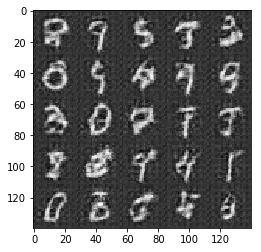

Epoch 1/2... Discriminator Loss: 1.9964... Generator Loss: 4.9122
Epoch 1/2... Discriminator Loss: 1.0007... Generator Loss: 0.8052
Epoch 1/2... Discriminator Loss: 0.7974... Generator Loss: 1.7669
Epoch 1/2... Discriminator Loss: 1.0666... Generator Loss: 0.5529
Epoch 1/2... Discriminator Loss: 1.9245... Generator Loss: 4.7816
Epoch 1/2... Discriminator Loss: 0.7059... Generator Loss: 2.8167
Epoch 1/2... Discriminator Loss: 0.3762... Generator Loss: 2.7648
Epoch 1/2... Discriminator Loss: 0.2516... Generator Loss: 1.8835
Epoch 1/2... Discriminator Loss: 0.1415... Generator Loss: 2.8625
Epoch 1/2... Discriminator Loss: 0.1186... Generator Loss: 2.8282


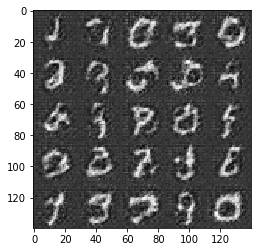

Epoch 1/2... Discriminator Loss: 0.1095... Generator Loss: 2.6273
Epoch 1/2... Discriminator Loss: 0.2995... Generator Loss: 1.6378
Epoch 1/2... Discriminator Loss: 0.1592... Generator Loss: 2.2278
Epoch 1/2... Discriminator Loss: 0.0540... Generator Loss: 3.8544
Epoch 1/2... Discriminator Loss: 0.1279... Generator Loss: 2.5241
Epoch 1/2... Discriminator Loss: 0.1626... Generator Loss: 2.2193
Epoch 1/2... Discriminator Loss: 0.0564... Generator Loss: 3.3789
Epoch 1/2... Discriminator Loss: 0.0209... Generator Loss: 4.7512
Epoch 1/2... Discriminator Loss: 0.0823... Generator Loss: 2.8886
Epoch 1/2... Discriminator Loss: 0.0430... Generator Loss: 4.0136


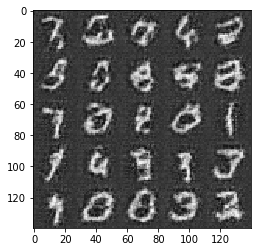

Epoch 1/2... Discriminator Loss: 0.5681... Generator Loss: 1.0500
Epoch 1/2... Discriminator Loss: 0.1695... Generator Loss: 2.1234
Epoch 1/2... Discriminator Loss: 0.2971... Generator Loss: 1.5865
Epoch 1/2... Discriminator Loss: 1.3687... Generator Loss: 1.6276
Epoch 1/2... Discriminator Loss: 1.1404... Generator Loss: 0.6059
Epoch 1/2... Discriminator Loss: 0.8965... Generator Loss: 1.0812
Epoch 1/2... Discriminator Loss: 1.1563... Generator Loss: 1.9303
Epoch 1/2... Discriminator Loss: 1.6266... Generator Loss: 0.2716
Epoch 1/2... Discriminator Loss: 1.0591... Generator Loss: 0.5517
Epoch 1/2... Discriminator Loss: 0.6737... Generator Loss: 1.1428


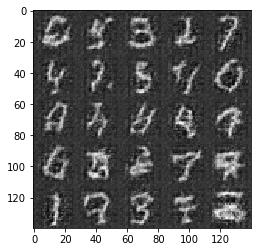

Epoch 1/2... Discriminator Loss: 0.7844... Generator Loss: 1.0147
Epoch 1/2... Discriminator Loss: 0.9121... Generator Loss: 0.7016
Epoch 1/2... Discriminator Loss: 0.5337... Generator Loss: 1.8343
Epoch 1/2... Discriminator Loss: 0.9128... Generator Loss: 0.6692
Epoch 1/2... Discriminator Loss: 0.4356... Generator Loss: 2.1193
Epoch 1/2... Discriminator Loss: 0.6647... Generator Loss: 2.2099
Epoch 1/2... Discriminator Loss: 0.8667... Generator Loss: 0.9226
Epoch 1/2... Discriminator Loss: 0.5284... Generator Loss: 1.0869
Epoch 1/2... Discriminator Loss: 0.7681... Generator Loss: 0.7772
Epoch 1/2... Discriminator Loss: 0.1175... Generator Loss: 2.6385


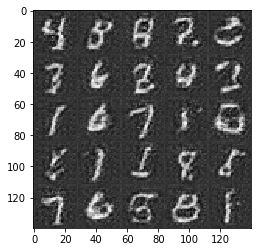

Epoch 1/2... Discriminator Loss: 0.1305... Generator Loss: 2.5586
Epoch 1/2... Discriminator Loss: 0.1828... Generator Loss: 2.0114
Epoch 1/2... Discriminator Loss: 0.0761... Generator Loss: 3.1603
Epoch 1/2... Discriminator Loss: 0.1217... Generator Loss: 2.6156
Epoch 1/2... Discriminator Loss: 0.1374... Generator Loss: 2.4532
Epoch 1/2... Discriminator Loss: 0.0315... Generator Loss: 5.0076
Epoch 1/2... Discriminator Loss: 0.2012... Generator Loss: 1.8710
Epoch 1/2... Discriminator Loss: 0.2655... Generator Loss: 1.6824
Epoch 1/2... Discriminator Loss: 0.0745... Generator Loss: 3.1841
Epoch 1/2... Discriminator Loss: 0.0249... Generator Loss: 4.3686


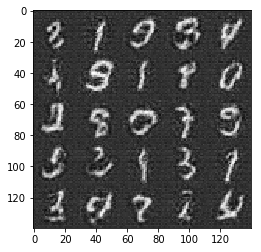

Epoch 1/2... Discriminator Loss: 0.0315... Generator Loss: 3.9641
Epoch 1/2... Discriminator Loss: 0.0634... Generator Loss: 3.1205
Epoch 1/2... Discriminator Loss: 0.0553... Generator Loss: 3.3272
Epoch 1/2... Discriminator Loss: 0.0287... Generator Loss: 4.2463
Epoch 1/2... Discriminator Loss: 0.0624... Generator Loss: 3.2101
Epoch 1/2... Discriminator Loss: 0.5889... Generator Loss: 1.0236
Epoch 1/2... Discriminator Loss: 1.2504... Generator Loss: 0.5780
Epoch 1/2... Discriminator Loss: 1.0964... Generator Loss: 0.5559
Epoch 1/2... Discriminator Loss: 0.8215... Generator Loss: 0.7731
Epoch 1/2... Discriminator Loss: 0.8044... Generator Loss: 0.7607


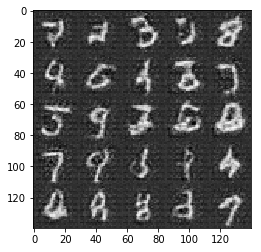

Epoch 1/2... Discriminator Loss: 0.7520... Generator Loss: 1.0644
Epoch 1/2... Discriminator Loss: 0.5993... Generator Loss: 1.2302
Epoch 1/2... Discriminator Loss: 0.5696... Generator Loss: 1.0503
Epoch 1/2... Discriminator Loss: 2.1668... Generator Loss: 0.1582
Epoch 1/2... Discriminator Loss: 0.3258... Generator Loss: 2.2504
Epoch 1/2... Discriminator Loss: 1.3623... Generator Loss: 4.8437
Epoch 1/2... Discriminator Loss: 0.5344... Generator Loss: 3.0252
Epoch 2/2... Discriminator Loss: 0.3536... Generator Loss: 2.3197
Epoch 2/2... Discriminator Loss: 0.3544... Generator Loss: 1.4775
Epoch 2/2... Discriminator Loss: 0.0971... Generator Loss: 2.8584


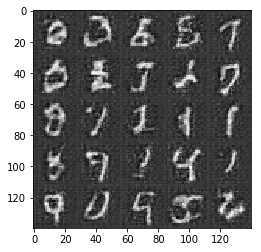

Epoch 2/2... Discriminator Loss: 0.1264... Generator Loss: 2.7398
Epoch 2/2... Discriminator Loss: 0.1323... Generator Loss: 2.5441
Epoch 2/2... Discriminator Loss: 0.0216... Generator Loss: 4.4660
Epoch 2/2... Discriminator Loss: 0.0171... Generator Loss: 6.1892
Epoch 2/2... Discriminator Loss: 0.0358... Generator Loss: 3.8193
Epoch 2/2... Discriminator Loss: 0.0886... Generator Loss: 3.7425
Epoch 2/2... Discriminator Loss: 0.1991... Generator Loss: 1.9321
Epoch 2/2... Discriminator Loss: 0.0846... Generator Loss: 2.7943
Epoch 2/2... Discriminator Loss: 3.4525... Generator Loss: 0.0682
Epoch 2/2... Discriminator Loss: 0.5840... Generator Loss: 1.2721


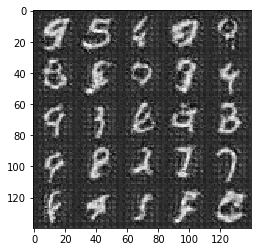

Epoch 2/2... Discriminator Loss: 0.6195... Generator Loss: 2.1498
Epoch 2/2... Discriminator Loss: 0.4343... Generator Loss: 1.7289
Epoch 2/2... Discriminator Loss: 0.6332... Generator Loss: 1.1054
Epoch 2/2... Discriminator Loss: 0.7019... Generator Loss: 0.9902
Epoch 2/2... Discriminator Loss: 0.5532... Generator Loss: 3.2913
Epoch 2/2... Discriminator Loss: 0.2907... Generator Loss: 2.3206
Epoch 2/2... Discriminator Loss: 0.3608... Generator Loss: 1.9625
Epoch 2/2... Discriminator Loss: 0.5907... Generator Loss: 1.0924
Epoch 2/2... Discriminator Loss: 0.2799... Generator Loss: 2.0024
Epoch 2/2... Discriminator Loss: 0.9094... Generator Loss: 0.6615


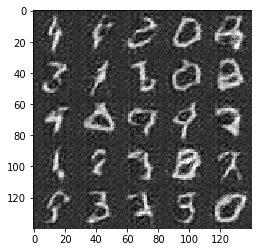

Epoch 2/2... Discriminator Loss: 0.5693... Generator Loss: 1.1991
Epoch 2/2... Discriminator Loss: 0.4378... Generator Loss: 1.3283
Epoch 2/2... Discriminator Loss: 0.2590... Generator Loss: 3.6381
Epoch 2/2... Discriminator Loss: 0.6753... Generator Loss: 0.9066
Epoch 2/2... Discriminator Loss: 0.1840... Generator Loss: 2.2052
Epoch 2/2... Discriminator Loss: 0.2280... Generator Loss: 1.8736
Epoch 2/2... Discriminator Loss: 0.0336... Generator Loss: 5.4172
Epoch 2/2... Discriminator Loss: 0.0629... Generator Loss: 4.2317
Epoch 2/2... Discriminator Loss: 0.0925... Generator Loss: 2.8299
Epoch 2/2... Discriminator Loss: 0.0716... Generator Loss: 3.1858


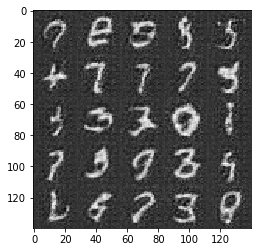

Epoch 2/2... Discriminator Loss: 0.0331... Generator Loss: 4.3163
Epoch 2/2... Discriminator Loss: 0.0912... Generator Loss: 2.8027
Epoch 2/2... Discriminator Loss: 0.0268... Generator Loss: 4.6974
Epoch 2/2... Discriminator Loss: 0.0453... Generator Loss: 3.5388
Epoch 2/2... Discriminator Loss: 0.0600... Generator Loss: 3.3439
Epoch 2/2... Discriminator Loss: 0.0594... Generator Loss: 3.4006
Epoch 2/2... Discriminator Loss: 0.0377... Generator Loss: 3.7868
Epoch 2/2... Discriminator Loss: 0.0276... Generator Loss: 3.8810
Epoch 2/2... Discriminator Loss: 0.0591... Generator Loss: 3.1230
Epoch 2/2... Discriminator Loss: 0.0175... Generator Loss: 4.6680


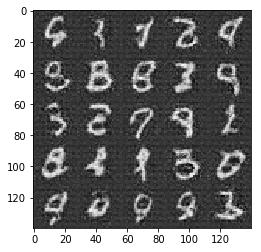

Epoch 2/2... Discriminator Loss: 0.0267... Generator Loss: 4.3313
Epoch 2/2... Discriminator Loss: 0.2117... Generator Loss: 2.0093
Epoch 2/2... Discriminator Loss: 0.0207... Generator Loss: 4.4330
Epoch 2/2... Discriminator Loss: 0.0755... Generator Loss: 3.1791
Epoch 2/2... Discriminator Loss: 0.0179... Generator Loss: 4.5320
Epoch 2/2... Discriminator Loss: 0.1015... Generator Loss: 2.8972
Epoch 2/2... Discriminator Loss: 0.0688... Generator Loss: 3.0601
Epoch 2/2... Discriminator Loss: 0.0236... Generator Loss: 5.4807
Epoch 2/2... Discriminator Loss: 0.1260... Generator Loss: 2.5112
Epoch 2/2... Discriminator Loss: 0.0396... Generator Loss: 3.5471


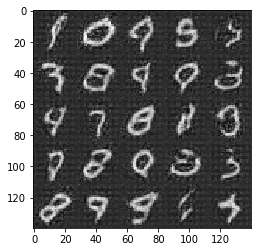

Epoch 2/2... Discriminator Loss: 0.0154... Generator Loss: 4.8882
Epoch 2/2... Discriminator Loss: 0.0096... Generator Loss: 5.7140
Epoch 2/2... Discriminator Loss: 0.0111... Generator Loss: 5.1159
Epoch 2/2... Discriminator Loss: 5.8206... Generator Loss: 0.0054
Epoch 2/2... Discriminator Loss: 0.5233... Generator Loss: 2.2437
Epoch 2/2... Discriminator Loss: 0.5278... Generator Loss: 1.0924
Epoch 2/2... Discriminator Loss: 1.4940... Generator Loss: 0.4396
Epoch 2/2... Discriminator Loss: 0.3881... Generator Loss: 3.1779
Epoch 2/2... Discriminator Loss: 0.8184... Generator Loss: 0.8368
Epoch 2/2... Discriminator Loss: 1.1176... Generator Loss: 3.1379


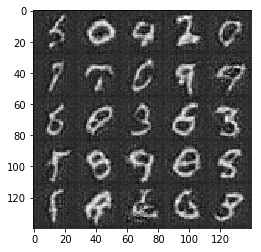

Epoch 2/2... Discriminator Loss: 0.5639... Generator Loss: 3.6169
Epoch 2/2... Discriminator Loss: 0.5533... Generator Loss: 1.1319
Epoch 2/2... Discriminator Loss: 0.5358... Generator Loss: 4.3631
Epoch 2/2... Discriminator Loss: 0.4654... Generator Loss: 1.5285
Epoch 2/2... Discriminator Loss: 0.4673... Generator Loss: 1.5626
Epoch 2/2... Discriminator Loss: 0.5878... Generator Loss: 0.9781
Epoch 2/2... Discriminator Loss: 0.5114... Generator Loss: 1.1570
Epoch 2/2... Discriminator Loss: 0.4429... Generator Loss: 1.5771
Epoch 2/2... Discriminator Loss: 0.3419... Generator Loss: 2.5808
Epoch 2/2... Discriminator Loss: 0.5945... Generator Loss: 1.0351


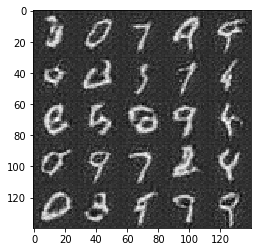

Epoch 2/2... Discriminator Loss: 0.2725... Generator Loss: 2.1498
Epoch 2/2... Discriminator Loss: 0.5305... Generator Loss: 1.3031
Epoch 2/2... Discriminator Loss: 0.2753... Generator Loss: 1.7767
Epoch 2/2... Discriminator Loss: 0.0802... Generator Loss: 3.0125
Epoch 2/2... Discriminator Loss: 0.1010... Generator Loss: 2.7065
Epoch 2/2... Discriminator Loss: 0.0423... Generator Loss: 4.1435
Epoch 2/2... Discriminator Loss: 0.1341... Generator Loss: 2.5270
Epoch 2/2... Discriminator Loss: 0.1332... Generator Loss: 2.4528
Epoch 2/2... Discriminator Loss: 0.0607... Generator Loss: 3.1369
Epoch 2/2... Discriminator Loss: 0.6053... Generator Loss: 0.9849


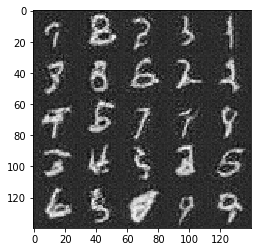

Epoch 2/2... Discriminator Loss: 0.0146... Generator Loss: 4.9747
Epoch 2/2... Discriminator Loss: 0.0834... Generator Loss: 2.8632
Epoch 2/2... Discriminator Loss: 0.0093... Generator Loss: 6.7987
Epoch 2/2... Discriminator Loss: 0.0056... Generator Loss: 5.9981
Epoch 2/2... Discriminator Loss: 0.0165... Generator Loss: 4.7655
Epoch 2/2... Discriminator Loss: 0.0349... Generator Loss: 7.8766
Epoch 2/2... Discriminator Loss: 1.6433... Generator Loss: 1.1421
Epoch 2/2... Discriminator Loss: 0.9365... Generator Loss: 1.0819
Epoch 2/2... Discriminator Loss: 0.6112... Generator Loss: 1.5217
Epoch 2/2... Discriminator Loss: 0.5068... Generator Loss: 2.6919


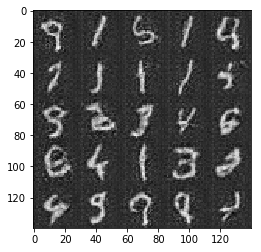

Epoch 2/2... Discriminator Loss: 0.3230... Generator Loss: 2.0745
Epoch 2/2... Discriminator Loss: 0.4649... Generator Loss: 1.2751
Epoch 2/2... Discriminator Loss: 1.7956... Generator Loss: 0.3339
Epoch 2/2... Discriminator Loss: 0.7266... Generator Loss: 3.9344
Epoch 2/2... Discriminator Loss: 0.2676... Generator Loss: 2.4365
Epoch 2/2... Discriminator Loss: 0.2348... Generator Loss: 2.0040
Epoch 2/2... Discriminator Loss: 0.2877... Generator Loss: 1.7664
Epoch 2/2... Discriminator Loss: 0.4033... Generator Loss: 1.2943
Epoch 2/2... Discriminator Loss: 0.0940... Generator Loss: 2.9231
Epoch 2/2... Discriminator Loss: 0.1591... Generator Loss: 2.1795


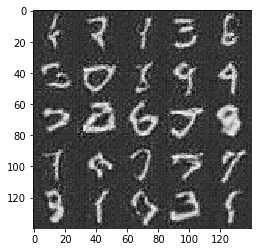

Epoch 2/2... Discriminator Loss: 0.1882... Generator Loss: 2.1811
Epoch 2/2... Discriminator Loss: 0.0617... Generator Loss: 3.4569
Epoch 2/2... Discriminator Loss: 0.0512... Generator Loss: 3.5483
Epoch 2/2... Discriminator Loss: 0.1061... Generator Loss: 2.7554
Epoch 2/2... Discriminator Loss: 0.2462... Generator Loss: 1.8032
Epoch 2/2... Discriminator Loss: 0.0783... Generator Loss: 2.9807
Epoch 2/2... Discriminator Loss: 2.7676... Generator Loss: 0.0859
Epoch 2/2... Discriminator Loss: 0.4053... Generator Loss: 1.9781
Epoch 2/2... Discriminator Loss: 0.1927... Generator Loss: 2.5101
Epoch 2/2... Discriminator Loss: 0.1659... Generator Loss: 2.2448


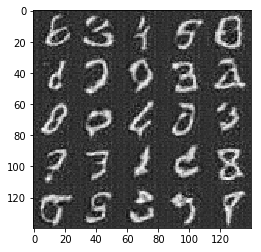

Epoch 2/2... Discriminator Loss: 0.0416... Generator Loss: 3.7730
Epoch 2/2... Discriminator Loss: 4.0587... Generator Loss: 7.2311
Epoch 2/2... Discriminator Loss: 0.5819... Generator Loss: 1.1690
Epoch 2/2... Discriminator Loss: 0.3539... Generator Loss: 1.6846
Epoch 2/2... Discriminator Loss: 0.1147... Generator Loss: 3.1887
Epoch 2/2... Discriminator Loss: 0.0672... Generator Loss: 3.2409
Epoch 2/2... Discriminator Loss: 0.3634... Generator Loss: 1.4535
Epoch 2/2... Discriminator Loss: 0.1796... Generator Loss: 3.6181
Epoch 2/2... Discriminator Loss: 0.1077... Generator Loss: 2.7670
Epoch 2/2... Discriminator Loss: 0.0727... Generator Loss: 3.2007


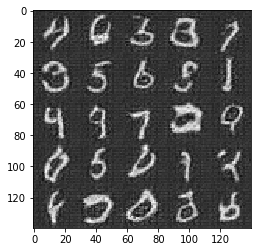

Epoch 2/2... Discriminator Loss: 0.0657... Generator Loss: 3.0917
Epoch 2/2... Discriminator Loss: 0.1802... Generator Loss: 2.4091
Epoch 2/2... Discriminator Loss: 0.0684... Generator Loss: 2.9967
Epoch 2/2... Discriminator Loss: 0.1094... Generator Loss: 2.6740
Epoch 2/2... Discriminator Loss: 0.0522... Generator Loss: 3.2912
Epoch 2/2... Discriminator Loss: 0.0225... Generator Loss: 5.1991
Epoch 2/2... Discriminator Loss: 0.1449... Generator Loss: 2.3589
Epoch 2/2... Discriminator Loss: 0.2392... Generator Loss: 1.8875
Epoch 2/2... Discriminator Loss: 0.0111... Generator Loss: 5.3890
Epoch 2/2... Discriminator Loss: 0.0220... Generator Loss: 4.2282


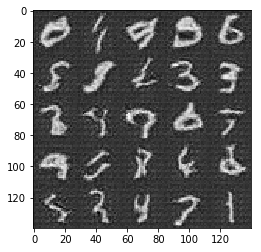

Epoch 2/2... Discriminator Loss: 0.0161... Generator Loss: 5.1540
Epoch 2/2... Discriminator Loss: 0.0330... Generator Loss: 3.9467
Epoch 2/2... Discriminator Loss: 0.3740... Generator Loss: 1.3199
Epoch 2/2... Discriminator Loss: 0.0110... Generator Loss: 6.4784
Epoch 2/2... Discriminator Loss: 0.0159... Generator Loss: 4.6625
Epoch 2/2... Discriminator Loss: 0.0274... Generator Loss: 4.0100
Epoch 2/2... Discriminator Loss: 0.0589... Generator Loss: 3.3170
Epoch 2/2... Discriminator Loss: 0.6764... Generator Loss: 0.9076
Epoch 2/2... Discriminator Loss: 0.0310... Generator Loss: 4.1060
Epoch 2/2... Discriminator Loss: 0.0406... Generator Loss: 3.5700


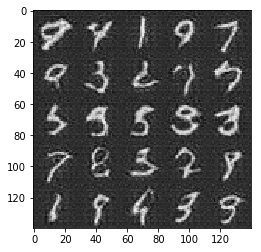

Epoch 2/2... Discriminator Loss: 0.0279... Generator Loss: 4.1609
Epoch 2/2... Discriminator Loss: 0.0511... Generator Loss: 3.3882
Epoch 2/2... Discriminator Loss: 0.0097... Generator Loss: 5.7116
Epoch 2/2... Discriminator Loss: 0.0052... Generator Loss: 6.5243
Epoch 2/2... Discriminator Loss: 0.0090... Generator Loss: 5.9323
Epoch 2/2... Discriminator Loss: 0.2264... Generator Loss: 1.8404
Epoch 2/2... Discriminator Loss: 0.0058... Generator Loss: 6.8300
Epoch 2/2... Discriminator Loss: 0.0284... Generator Loss: 4.2304
Epoch 2/2... Discriminator Loss: 0.0144... Generator Loss: 5.8783
Epoch 2/2... Discriminator Loss: 0.0587... Generator Loss: 3.1145


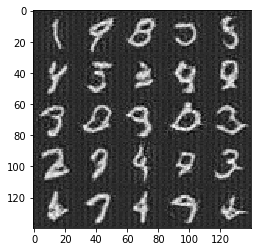

Epoch 2/2... Discriminator Loss: 0.0124... Generator Loss: 4.9081
Epoch 2/2... Discriminator Loss: 0.0458... Generator Loss: 3.5706
Epoch 2/2... Discriminator Loss: 0.0217... Generator Loss: 4.4667
Epoch 2/2... Discriminator Loss: 0.0506... Generator Loss: 3.3859
Epoch 2/2... Discriminator Loss: 0.0047... Generator Loss: 7.3398
Epoch 2/2... Discriminator Loss: 0.0492... Generator Loss: 7.0537
Epoch 2/2... Discriminator Loss: 0.1030... Generator Loss: 2.7869
Epoch 2/2... Discriminator Loss: 0.0138... Generator Loss: 4.6353
Epoch 2/2... Discriminator Loss: 0.0560... Generator Loss: 3.1857
Epoch 2/2... Discriminator Loss: 0.0287... Generator Loss: 3.9067


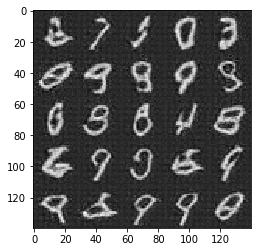

Epoch 2/2... Discriminator Loss: 0.0014... Generator Loss: 7.0336
Epoch 2/2... Discriminator Loss: 0.0105... Generator Loss: 5.1299
Epoch 2/2... Discriminator Loss: 0.0987... Generator Loss: 2.6013
Epoch 2/2... Discriminator Loss: 0.0426... Generator Loss: 3.5004
Epoch 2/2... Discriminator Loss: 0.1149... Generator Loss: 2.7994
Epoch 2/2... Discriminator Loss: 0.5132... Generator Loss: 1.2474
Epoch 2/2... Discriminator Loss: 0.0289... Generator Loss: 4.3629
Epoch 2/2... Discriminator Loss: 0.0179... Generator Loss: 4.7564
Epoch 2/2... Discriminator Loss: 0.0126... Generator Loss: 5.0968
Epoch 2/2... Discriminator Loss: 0.0115... Generator Loss: 5.0617


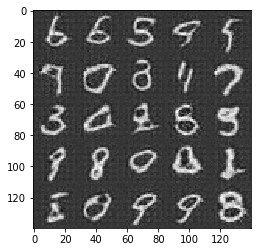

Epoch 2/2... Discriminator Loss: 0.0034... Generator Loss: 6.5526
Epoch 2/2... Discriminator Loss: 0.0032... Generator Loss: 6.5510
Epoch 2/2... Discriminator Loss: 0.0033... Generator Loss: 7.1511
Epoch 2/2... Discriminator Loss: 0.0107... Generator Loss: 4.8802
Epoch 2/2... Discriminator Loss: 0.1001... Generator Loss: 2.7992
Epoch 2/2... Discriminator Loss: 0.0619... Generator Loss: 3.1825
Epoch 2/2... Discriminator Loss: 0.0238... Generator Loss: 6.8053
Epoch 2/2... Discriminator Loss: 0.0235... Generator Loss: 3.9894
Epoch 2/2... Discriminator Loss: 0.0403... Generator Loss: 3.8705
Epoch 2/2... Discriminator Loss: 1.1691... Generator Loss: 0.4394


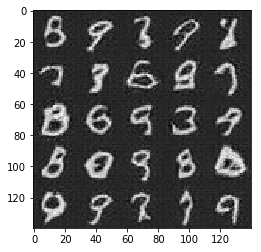

Epoch 2/2... Discriminator Loss: 2.0456... Generator Loss: 0.2547
Epoch 2/2... Discriminator Loss: 0.4878... Generator Loss: 2.0324
Epoch 2/2... Discriminator Loss: 0.8690... Generator Loss: 0.7203
Epoch 2/2... Discriminator Loss: 0.4310... Generator Loss: 1.7151
Epoch 2/2... Discriminator Loss: 0.5670... Generator Loss: 1.3317


In [303]:
batch_size = 32
z_dim = 150
learning_rate = 0.0005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.7161... Generator Loss: 0.0297
Epoch 1/1... Discriminator Loss: 0.0175... Generator Loss: 10.1346
Epoch 1/1... Discriminator Loss: 0.0917... Generator Loss: 2.9410
Epoch 1/1... Discriminator Loss: 0.1054... Generator Loss: 7.9022
Epoch 1/1... Discriminator Loss: 0.3441... Generator Loss: 4.7837
Epoch 1/1... Discriminator Loss: 0.5657... Generator Loss: 1.0489
Epoch 1/1... Discriminator Loss: 0.5636... Generator Loss: 1.4165
Epoch 1/1... Discriminator Loss: 2.5897... Generator Loss: 14.2512
Epoch 1/1... Discriminator Loss: 0.1226... Generator Loss: 4.9552
Epoch 1/1... Discriminator Loss: 0.2603... Generator Loss: 1.7263


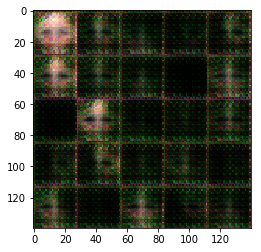

Epoch 1/1... Discriminator Loss: 0.0556... Generator Loss: 7.5036
Epoch 1/1... Discriminator Loss: 0.0053... Generator Loss: 6.9296
Epoch 1/1... Discriminator Loss: 0.2502... Generator Loss: 2.4465
Epoch 1/1... Discriminator Loss: 0.0116... Generator Loss: 7.5442
Epoch 1/1... Discriminator Loss: 1.6445... Generator Loss: 0.3192
Epoch 1/1... Discriminator Loss: 0.6948... Generator Loss: 1.0703
Epoch 1/1... Discriminator Loss: 0.6681... Generator Loss: 1.2064
Epoch 1/1... Discriminator Loss: 0.3998... Generator Loss: 2.0823
Epoch 1/1... Discriminator Loss: 0.0420... Generator Loss: 5.7213
Epoch 1/1... Discriminator Loss: 0.3003... Generator Loss: 1.7290


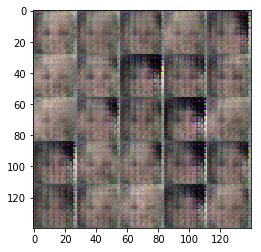

Epoch 1/1... Discriminator Loss: 0.4806... Generator Loss: 1.2170
Epoch 1/1... Discriminator Loss: 0.1298... Generator Loss: 2.4995
Epoch 1/1... Discriminator Loss: 1.7166... Generator Loss: 0.5361
Epoch 1/1... Discriminator Loss: 3.9456... Generator Loss: 7.7089
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.5043
Epoch 1/1... Discriminator Loss: 3.4482... Generator Loss: 0.0468
Epoch 1/1... Discriminator Loss: 0.1189... Generator Loss: 6.1432
Epoch 1/1... Discriminator Loss: 0.1057... Generator Loss: 4.6676
Epoch 1/1... Discriminator Loss: 0.0558... Generator Loss: 4.2199
Epoch 1/1... Discriminator Loss: 0.1199... Generator Loss: 2.6360


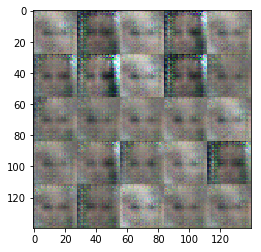

Epoch 1/1... Discriminator Loss: 0.0336... Generator Loss: 5.4947
Epoch 1/1... Discriminator Loss: 0.5099... Generator Loss: 1.6744
Epoch 1/1... Discriminator Loss: 0.4775... Generator Loss: 1.7753
Epoch 1/1... Discriminator Loss: 0.0175... Generator Loss: 6.4299
Epoch 1/1... Discriminator Loss: 0.1930... Generator Loss: 5.4895
Epoch 1/1... Discriminator Loss: 0.3406... Generator Loss: 3.3475
Epoch 1/1... Discriminator Loss: 0.0856... Generator Loss: 5.2240
Epoch 1/1... Discriminator Loss: 0.0358... Generator Loss: 4.3773
Epoch 1/1... Discriminator Loss: 0.0113... Generator Loss: 5.6500
Epoch 1/1... Discriminator Loss: 0.9497... Generator Loss: 4.2477


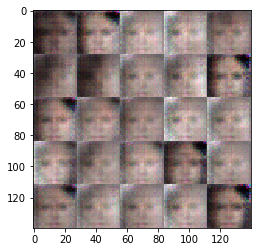

Epoch 1/1... Discriminator Loss: 2.7128... Generator Loss: 4.8222
Epoch 1/1... Discriminator Loss: 0.0234... Generator Loss: 4.6725
Epoch 1/1... Discriminator Loss: 0.0158... Generator Loss: 5.9003
Epoch 1/1... Discriminator Loss: 0.0308... Generator Loss: 5.9262
Epoch 1/1... Discriminator Loss: 0.1096... Generator Loss: 2.6621
Epoch 1/1... Discriminator Loss: 0.1448... Generator Loss: 2.5924
Epoch 1/1... Discriminator Loss: 0.1905... Generator Loss: 2.1502
Epoch 1/1... Discriminator Loss: 6.1429... Generator Loss: 6.1722
Epoch 1/1... Discriminator Loss: 0.2590... Generator Loss: 2.3168
Epoch 1/1... Discriminator Loss: 0.1051... Generator Loss: 3.7881


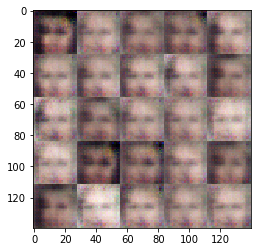

Epoch 1/1... Discriminator Loss: 0.0259... Generator Loss: 4.8792
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 4.7153
Epoch 1/1... Discriminator Loss: 0.0391... Generator Loss: 5.6651
Epoch 1/1... Discriminator Loss: 0.0252... Generator Loss: 5.7240
Epoch 1/1... Discriminator Loss: 0.0110... Generator Loss: 9.5786
Epoch 1/1... Discriminator Loss: 0.0139... Generator Loss: 8.8092
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 3.0546
Epoch 1/1... Discriminator Loss: 0.1649... Generator Loss: 2.2579
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 0.5818


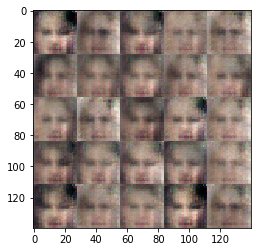

Epoch 1/1... Discriminator Loss: 0.0248... Generator Loss: 7.1826
Epoch 1/1... Discriminator Loss: 0.1045... Generator Loss: 3.0780
Epoch 1/1... Discriminator Loss: 0.0249... Generator Loss: 4.2876
Epoch 1/1... Discriminator Loss: 0.1995... Generator Loss: 2.3369
Epoch 1/1... Discriminator Loss: 0.0089... Generator Loss: 6.5106
Epoch 1/1... Discriminator Loss: 0.0265... Generator Loss: 5.3800
Epoch 1/1... Discriminator Loss: 2.4086... Generator Loss: 0.2765
Epoch 1/1... Discriminator Loss: 1.6667... Generator Loss: 0.2675
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 0.1316... Generator Loss: 3.1209


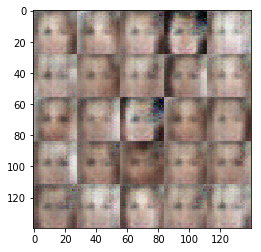

Epoch 1/1... Discriminator Loss: 0.0465... Generator Loss: 5.8183
Epoch 1/1... Discriminator Loss: 0.3202... Generator Loss: 1.5038
Epoch 1/1... Discriminator Loss: 1.6332... Generator Loss: 0.2701
Epoch 1/1... Discriminator Loss: 0.4367... Generator Loss: 1.2883
Epoch 1/1... Discriminator Loss: 0.3213... Generator Loss: 2.1199
Epoch 1/1... Discriminator Loss: 0.2412... Generator Loss: 1.7448
Epoch 1/1... Discriminator Loss: 0.1665... Generator Loss: 2.3996
Epoch 1/1... Discriminator Loss: 0.0950... Generator Loss: 3.3746
Epoch 1/1... Discriminator Loss: 0.2074... Generator Loss: 1.8077
Epoch 1/1... Discriminator Loss: 0.0092... Generator Loss: 7.4705


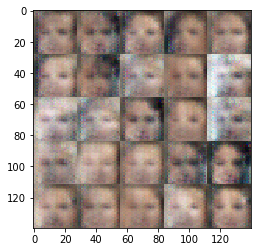

Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 1.1951
Epoch 1/1... Discriminator Loss: 0.1016... Generator Loss: 3.7278
Epoch 1/1... Discriminator Loss: 0.2702... Generator Loss: 3.2200
Epoch 1/1... Discriminator Loss: 2.4995... Generator Loss: 0.1475
Epoch 1/1... Discriminator Loss: 0.5389... Generator Loss: 4.4513
Epoch 1/1... Discriminator Loss: 0.0823... Generator Loss: 3.4091
Epoch 1/1... Discriminator Loss: 0.3236... Generator Loss: 5.0909
Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 1.3207
Epoch 1/1... Discriminator Loss: 0.6309... Generator Loss: 1.9167
Epoch 1/1... Discriminator Loss: 0.0841... Generator Loss: 3.7356


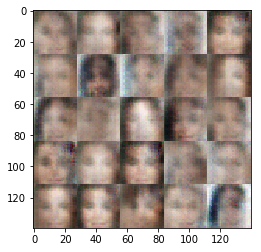

Epoch 1/1... Discriminator Loss: 0.1712... Generator Loss: 2.1453
Epoch 1/1... Discriminator Loss: 0.0419... Generator Loss: 4.3213
Epoch 1/1... Discriminator Loss: 0.0874... Generator Loss: 3.0855
Epoch 1/1... Discriminator Loss: 3.3457... Generator Loss: 5.0743
Epoch 1/1... Discriminator Loss: 0.8203... Generator Loss: 4.8847
Epoch 1/1... Discriminator Loss: 0.0582... Generator Loss: 3.9756
Epoch 1/1... Discriminator Loss: 0.0544... Generator Loss: 3.9216
Epoch 1/1... Discriminator Loss: 1.5431... Generator Loss: 1.3455
Epoch 1/1... Discriminator Loss: 0.0629... Generator Loss: 3.3372
Epoch 1/1... Discriminator Loss: 0.0489... Generator Loss: 3.2947


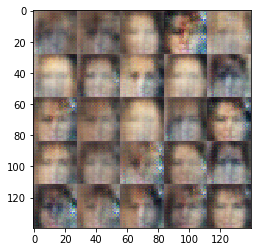

Epoch 1/1... Discriminator Loss: 0.0405... Generator Loss: 5.7194
Epoch 1/1... Discriminator Loss: 1.7662... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 2.1297... Generator Loss: 2.7822
Epoch 1/1... Discriminator Loss: 0.1879... Generator Loss: 2.1904
Epoch 1/1... Discriminator Loss: 2.0392... Generator Loss: 1.1573
Epoch 1/1... Discriminator Loss: 0.3921... Generator Loss: 2.4298
Epoch 1/1... Discriminator Loss: 0.0809... Generator Loss: 3.3350
Epoch 1/1... Discriminator Loss: 0.1593... Generator Loss: 5.4745
Epoch 1/1... Discriminator Loss: 1.7239... Generator Loss: 3.7411
Epoch 1/1... Discriminator Loss: 0.0347... Generator Loss: 5.0045


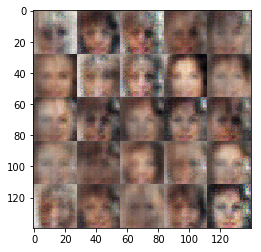

Epoch 1/1... Discriminator Loss: 0.7947... Generator Loss: 1.3570
Epoch 1/1... Discriminator Loss: 0.2008... Generator Loss: 3.8289
Epoch 1/1... Discriminator Loss: 0.2747... Generator Loss: 4.5746
Epoch 1/1... Discriminator Loss: 0.0504... Generator Loss: 5.2800
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 7.9378
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 0.5966
Epoch 1/1... Discriminator Loss: 0.2019... Generator Loss: 2.1713
Epoch 1/1... Discriminator Loss: 0.3975... Generator Loss: 6.0874
Epoch 1/1... Discriminator Loss: 0.0558... Generator Loss: 5.0464
Epoch 1/1... Discriminator Loss: 4.6667... Generator Loss: 6.3587


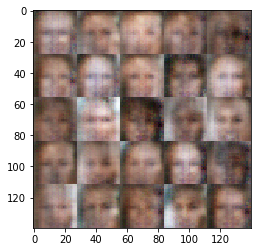

Epoch 1/1... Discriminator Loss: 0.2036... Generator Loss: 2.4995
Epoch 1/1... Discriminator Loss: 0.0643... Generator Loss: 5.1129
Epoch 1/1... Discriminator Loss: 1.8199... Generator Loss: 0.2274
Epoch 1/1... Discriminator Loss: 0.3052... Generator Loss: 1.5029
Epoch 1/1... Discriminator Loss: 0.5054... Generator Loss: 3.6443
Epoch 1/1... Discriminator Loss: 0.6301... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 0.5614... Generator Loss: 2.3613
Epoch 1/1... Discriminator Loss: 0.0351... Generator Loss: 6.2445
Epoch 1/1... Discriminator Loss: 0.4708... Generator Loss: 1.1471
Epoch 1/1... Discriminator Loss: 0.0629... Generator Loss: 5.7730


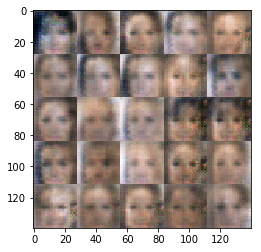

Epoch 1/1... Discriminator Loss: 0.3530... Generator Loss: 1.3164
Epoch 1/1... Discriminator Loss: 0.1378... Generator Loss: 2.4053
Epoch 1/1... Discriminator Loss: 0.0322... Generator Loss: 4.8435
Epoch 1/1... Discriminator Loss: 0.0601... Generator Loss: 3.4364
Epoch 1/1... Discriminator Loss: 0.0380... Generator Loss: 4.2070
Epoch 1/1... Discriminator Loss: 0.0177... Generator Loss: 6.3035
Epoch 1/1... Discriminator Loss: 0.0418... Generator Loss: 9.1936
Epoch 1/1... Discriminator Loss: 0.0105... Generator Loss: 5.6701
Epoch 1/1... Discriminator Loss: 2.4711... Generator Loss: 0.1664
Epoch 1/1... Discriminator Loss: 0.8713... Generator Loss: 1.3078


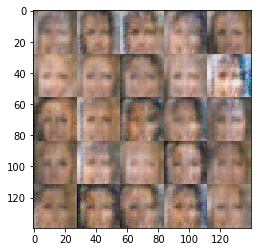

Epoch 1/1... Discriminator Loss: 0.7661... Generator Loss: 1.6702
Epoch 1/1... Discriminator Loss: 2.1213... Generator Loss: 3.6121
Epoch 1/1... Discriminator Loss: 0.1470... Generator Loss: 3.9209
Epoch 1/1... Discriminator Loss: 1.6448... Generator Loss: 4.0386
Epoch 1/1... Discriminator Loss: 0.6192... Generator Loss: 1.0487
Epoch 1/1... Discriminator Loss: 0.7796... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 0.2466... Generator Loss: 4.3252
Epoch 1/1... Discriminator Loss: 0.4197... Generator Loss: 1.4316
Epoch 1/1... Discriminator Loss: 0.0826... Generator Loss: 5.3853
Epoch 1/1... Discriminator Loss: 0.0214... Generator Loss: 5.2148


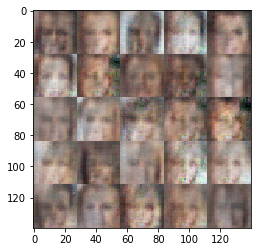

Epoch 1/1... Discriminator Loss: 2.0723... Generator Loss: 1.8807
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 1.0243
Epoch 1/1... Discriminator Loss: 0.9201... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.5212
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 2.0511
Epoch 1/1... Discriminator Loss: 0.7873... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 6.1974


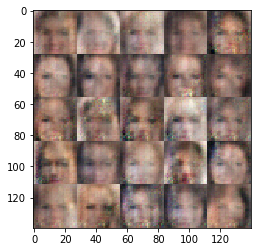

Epoch 1/1... Discriminator Loss: 0.2992... Generator Loss: 1.8555
Epoch 1/1... Discriminator Loss: 0.1463... Generator Loss: 2.4762
Epoch 1/1... Discriminator Loss: 4.4163... Generator Loss: 0.0164
Epoch 1/1... Discriminator Loss: 0.5045... Generator Loss: 5.1575
Epoch 1/1... Discriminator Loss: 0.3035... Generator Loss: 5.8320
Epoch 1/1... Discriminator Loss: 0.2529... Generator Loss: 5.1678
Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 0.5783... Generator Loss: 2.0082
Epoch 1/1... Discriminator Loss: 0.0732... Generator Loss: 4.1842


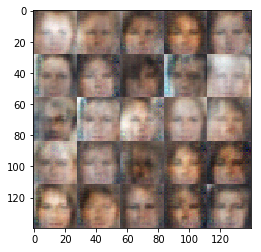

Epoch 1/1... Discriminator Loss: 0.1891... Generator Loss: 2.0698
Epoch 1/1... Discriminator Loss: 0.1304... Generator Loss: 2.5537
Epoch 1/1... Discriminator Loss: 0.1884... Generator Loss: 2.2698
Epoch 1/1... Discriminator Loss: 2.0808... Generator Loss: 2.3677
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 1.2087
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 1.0393
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.4445
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.4493


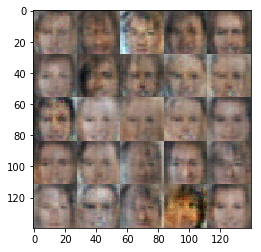

Epoch 1/1... Discriminator Loss: 0.9343... Generator Loss: 1.4494
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.4862
Epoch 1/1... Discriminator Loss: 1.6645... Generator Loss: 0.4411
Epoch 1/1... Discriminator Loss: 0.3556... Generator Loss: 1.3791
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 4.9064
Epoch 1/1... Discriminator Loss: 0.1853... Generator Loss: 3.3534
Epoch 1/1... Discriminator Loss: 0.1479... Generator Loss: 2.3882
Epoch 1/1... Discriminator Loss: 0.7879... Generator Loss: 1.1482
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 0.2086... Generator Loss: 2.1257


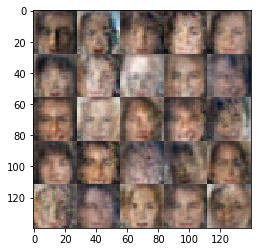

Epoch 1/1... Discriminator Loss: 0.2214... Generator Loss: 4.7755
Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.8424... Generator Loss: 0.2430
Epoch 1/1... Discriminator Loss: 0.3525... Generator Loss: 1.5186
Epoch 1/1... Discriminator Loss: 0.7652... Generator Loss: 3.0746
Epoch 1/1... Discriminator Loss: 0.1595... Generator Loss: 2.1497
Epoch 1/1... Discriminator Loss: 0.6816... Generator Loss: 4.4205
Epoch 1/1... Discriminator Loss: 0.4122... Generator Loss: 1.2069
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.4819
Epoch 1/1... Discriminator Loss: 0.0970... Generator Loss: 3.6154


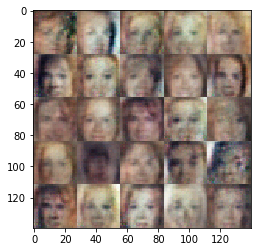

Epoch 1/1... Discriminator Loss: 0.1849... Generator Loss: 1.9988
Epoch 1/1... Discriminator Loss: 0.3452... Generator Loss: 2.6524
Epoch 1/1... Discriminator Loss: 0.2755... Generator Loss: 1.6826
Epoch 1/1... Discriminator Loss: 0.1511... Generator Loss: 2.6206
Epoch 1/1... Discriminator Loss: 1.0562... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 0.1994... Generator Loss: 4.5678
Epoch 1/1... Discriminator Loss: 0.1454... Generator Loss: 3.5506
Epoch 1/1... Discriminator Loss: 0.0303... Generator Loss: 4.4782
Epoch 1/1... Discriminator Loss: 0.0420... Generator Loss: 4.4853
Epoch 1/1... Discriminator Loss: 0.8181... Generator Loss: 0.7784


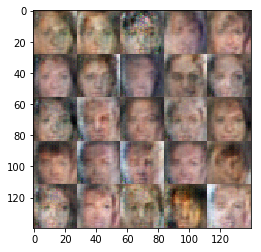

Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 1.7616
Epoch 1/1... Discriminator Loss: 0.0681... Generator Loss: 5.2346
Epoch 1/1... Discriminator Loss: 0.0287... Generator Loss: 4.3854
Epoch 1/1... Discriminator Loss: 2.0879... Generator Loss: 0.1664
Epoch 1/1... Discriminator Loss: 0.0983... Generator Loss: 2.7110
Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 0.4011
Epoch 1/1... Discriminator Loss: 0.2442... Generator Loss: 4.4569
Epoch 1/1... Discriminator Loss: 0.0560... Generator Loss: 4.9407
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 0.4547
Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 0.6076


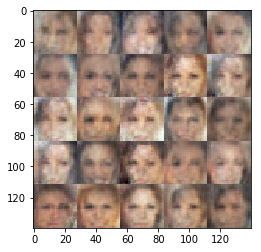

Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 2.3832
Epoch 1/1... Discriminator Loss: 0.3388... Generator Loss: 5.8211
Epoch 1/1... Discriminator Loss: 2.3388... Generator Loss: 4.7246
Epoch 1/1... Discriminator Loss: 0.2212... Generator Loss: 2.1438
Epoch 1/1... Discriminator Loss: 0.5334... Generator Loss: 6.2690
Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 4.1621
Epoch 1/1... Discriminator Loss: 0.0960... Generator Loss: 2.9801
Epoch 1/1... Discriminator Loss: 3.2595... Generator Loss: 3.9751
Epoch 1/1... Discriminator Loss: 0.1339... Generator Loss: 3.5615
Epoch 1/1... Discriminator Loss: 0.2689... Generator Loss: 4.8656


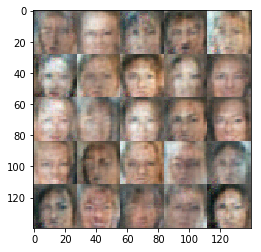

Epoch 1/1... Discriminator Loss: 0.8630... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 0.4002... Generator Loss: 1.3384
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.3702
Epoch 1/1... Discriminator Loss: 0.1610... Generator Loss: 2.2990
Epoch 1/1... Discriminator Loss: 0.0497... Generator Loss: 3.8956
Epoch 1/1... Discriminator Loss: 0.0241... Generator Loss: 5.7900
Epoch 1/1... Discriminator Loss: 0.7431... Generator Loss: 1.1475
Epoch 1/1... Discriminator Loss: 1.6413... Generator Loss: 0.3370
Epoch 1/1... Discriminator Loss: 0.8589... Generator Loss: 0.8841


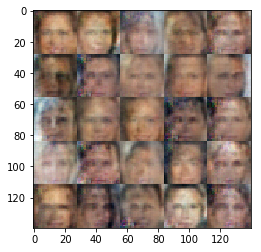

Epoch 1/1... Discriminator Loss: 0.5399... Generator Loss: 2.6073
Epoch 1/1... Discriminator Loss: 0.6335... Generator Loss: 0.9521
Epoch 1/1... Discriminator Loss: 0.0345... Generator Loss: 5.7937
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 2.2055... Generator Loss: 0.1545
Epoch 1/1... Discriminator Loss: 0.0429... Generator Loss: 5.0228
Epoch 1/1... Discriminator Loss: 0.2860... Generator Loss: 5.4278
Epoch 1/1... Discriminator Loss: 0.4173... Generator Loss: 2.1925
Epoch 1/1... Discriminator Loss: 0.0337... Generator Loss: 4.3955
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 2.2703


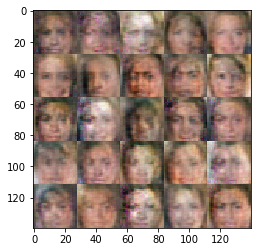

Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 1.4751
Epoch 1/1... Discriminator Loss: 0.4114... Generator Loss: 1.5376
Epoch 1/1... Discriminator Loss: 0.2360... Generator Loss: 1.9476
Epoch 1/1... Discriminator Loss: 0.4930... Generator Loss: 1.2745
Epoch 1/1... Discriminator Loss: 0.7038... Generator Loss: 3.1846
Epoch 1/1... Discriminator Loss: 2.8327... Generator Loss: 4.6614
Epoch 1/1... Discriminator Loss: 0.0673... Generator Loss: 4.6071
Epoch 1/1... Discriminator Loss: 0.0960... Generator Loss: 3.6957
Epoch 1/1... Discriminator Loss: 0.3910... Generator Loss: 3.3312
Epoch 1/1... Discriminator Loss: 0.7751... Generator Loss: 0.8147


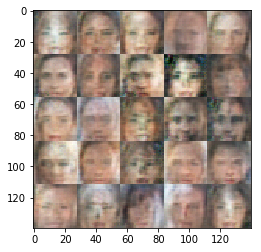

Epoch 1/1... Discriminator Loss: 3.1143... Generator Loss: 0.0767
Epoch 1/1... Discriminator Loss: 0.4365... Generator Loss: 4.9970
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 3.9093
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 0.2472... Generator Loss: 3.5268
Epoch 1/1... Discriminator Loss: 0.2513... Generator Loss: 4.6929
Epoch 1/1... Discriminator Loss: 0.6623... Generator Loss: 4.7684
Epoch 1/1... Discriminator Loss: 0.0777... Generator Loss: 4.0467
Epoch 1/1... Discriminator Loss: 0.0743... Generator Loss: 3.4042
Epoch 1/1... Discriminator Loss: 0.1311... Generator Loss: 2.7053


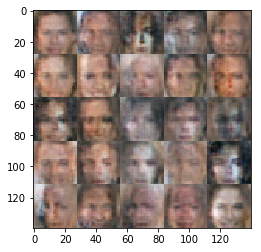

Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 1.8628
Epoch 1/1... Discriminator Loss: 0.4765... Generator Loss: 1.7006
Epoch 1/1... Discriminator Loss: 0.6519... Generator Loss: 0.9521
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.4438
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.4776
Epoch 1/1... Discriminator Loss: 0.0720... Generator Loss: 4.3775
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 1.5088
Epoch 1/1... Discriminator Loss: 0.8954... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 0.5103... Generator Loss: 1.2771
Epoch 1/1... Discriminator Loss: 0.7236... Generator Loss: 0.8668


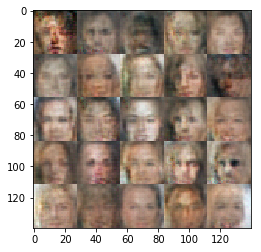

Epoch 1/1... Discriminator Loss: 0.0428... Generator Loss: 4.5922
Epoch 1/1... Discriminator Loss: 4.4430... Generator Loss: 0.0185
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.5230
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.3823
Epoch 1/1... Discriminator Loss: 0.5980... Generator Loss: 1.1833
Epoch 1/1... Discriminator Loss: 0.6425... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 3.7959
Epoch 1/1... Discriminator Loss: 0.5543... Generator Loss: 1.1375
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 2.6540
Epoch 1/1... Discriminator Loss: 0.1149... Generator Loss: 3.3491


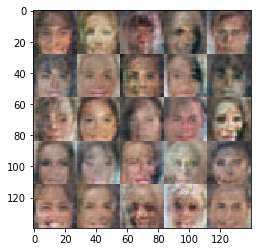

Epoch 1/1... Discriminator Loss: 0.0678... Generator Loss: 3.8092
Epoch 1/1... Discriminator Loss: 0.4059... Generator Loss: 1.4309
Epoch 1/1... Discriminator Loss: 0.4855... Generator Loss: 1.3056
Epoch 1/1... Discriminator Loss: 0.1020... Generator Loss: 2.7733
Epoch 1/1... Discriminator Loss: 0.2981... Generator Loss: 2.6458
Epoch 1/1... Discriminator Loss: 2.7456... Generator Loss: 4.3461
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.8305... Generator Loss: 0.2382
Epoch 1/1... Discriminator Loss: 0.0922... Generator Loss: 5.6048
Epoch 1/1... Discriminator Loss: 0.0244... Generator Loss: 5.0505


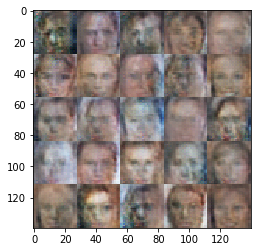

Epoch 1/1... Discriminator Loss: 0.0258... Generator Loss: 6.8826
Epoch 1/1... Discriminator Loss: 0.5194... Generator Loss: 1.2821
Epoch 1/1... Discriminator Loss: 0.2115... Generator Loss: 2.7264
Epoch 1/1... Discriminator Loss: 0.8116... Generator Loss: 1.3014
Epoch 1/1... Discriminator Loss: 0.2329... Generator Loss: 2.7998
Epoch 1/1... Discriminator Loss: 0.2293... Generator Loss: 2.0342
Epoch 1/1... Discriminator Loss: 0.0326... Generator Loss: 4.8263
Epoch 1/1... Discriminator Loss: 0.0844... Generator Loss: 2.8204
Epoch 1/1... Discriminator Loss: 0.0266... Generator Loss: 6.9067
Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 0.4353


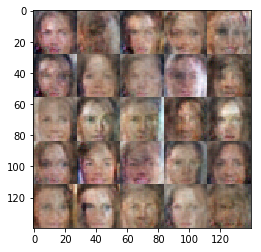

Epoch 1/1... Discriminator Loss: 0.1408... Generator Loss: 2.4695
Epoch 1/1... Discriminator Loss: 0.1650... Generator Loss: 2.1340
Epoch 1/1... Discriminator Loss: 0.4376... Generator Loss: 2.3796
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.4252
Epoch 1/1... Discriminator Loss: 0.0580... Generator Loss: 3.3444
Epoch 1/1... Discriminator Loss: 0.2603... Generator Loss: 1.8220
Epoch 1/1... Discriminator Loss: 0.3125... Generator Loss: 4.7990
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 0.3711... Generator Loss: 2.4164


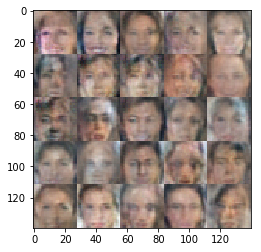

Epoch 1/1... Discriminator Loss: 0.3468... Generator Loss: 1.7317
Epoch 1/1... Discriminator Loss: 0.1025... Generator Loss: 4.2100
Epoch 1/1... Discriminator Loss: 0.6871... Generator Loss: 0.9802
Epoch 1/1... Discriminator Loss: 0.0834... Generator Loss: 4.1387
Epoch 1/1... Discriminator Loss: 0.0933... Generator Loss: 4.1122
Epoch 1/1... Discriminator Loss: 1.7334... Generator Loss: 4.5864
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 0.0844... Generator Loss: 6.3683
Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 2.4780
Epoch 1/1... Discriminator Loss: 0.2854... Generator Loss: 2.1522


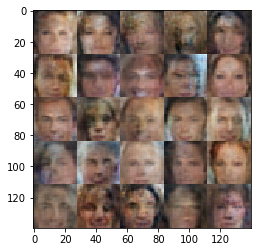

Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 4.0042
Epoch 1/1... Discriminator Loss: 2.6653... Generator Loss: 0.1014
Epoch 1/1... Discriminator Loss: 0.5410... Generator Loss: 1.1067
Epoch 1/1... Discriminator Loss: 0.1763... Generator Loss: 2.3231
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 6.0428
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 1.0387
Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 4.0606
Epoch 1/1... Discriminator Loss: 0.6313... Generator Loss: 1.6787
Epoch 1/1... Discriminator Loss: 0.6758... Generator Loss: 1.1280
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 2.7524


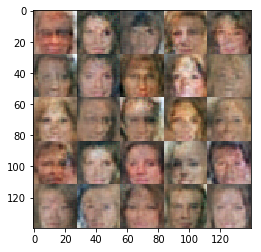

Epoch 1/1... Discriminator Loss: 0.5566... Generator Loss: 1.5099
Epoch 1/1... Discriminator Loss: 0.5018... Generator Loss: 1.1238
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 0.5517... Generator Loss: 1.8583
Epoch 1/1... Discriminator Loss: 0.3462... Generator Loss: 1.7711
Epoch 1/1... Discriminator Loss: 2.2142... Generator Loss: 0.1668
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 3.0982
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.5158
Epoch 1/1... Discriminator Loss: 0.3292... Generator Loss: 1.7950
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 0.5239


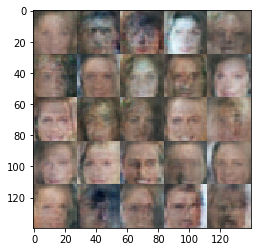

Epoch 1/1... Discriminator Loss: 0.6492... Generator Loss: 1.8355
Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 2.2230
Epoch 1/1... Discriminator Loss: 0.1753... Generator Loss: 2.6190
Epoch 1/1... Discriminator Loss: 0.7822... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 0.2318... Generator Loss: 2.5336
Epoch 1/1... Discriminator Loss: 0.1108... Generator Loss: 3.2987
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 1.3176
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.4075
Epoch 1/1... Discriminator Loss: 0.7795... Generator Loss: 1.2609
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.4183


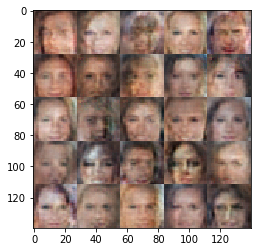

Epoch 1/1... Discriminator Loss: 0.7473... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 0.5602... Generator Loss: 1.0748
Epoch 1/1... Discriminator Loss: 0.1771... Generator Loss: 2.4393
Epoch 1/1... Discriminator Loss: 0.4847... Generator Loss: 1.1716
Epoch 1/1... Discriminator Loss: 0.7038... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 1.0204
Epoch 1/1... Discriminator Loss: 0.1259... Generator Loss: 2.7456
Epoch 1/1... Discriminator Loss: 0.2040... Generator Loss: 2.5852
Epoch 1/1... Discriminator Loss: 5.7421... Generator Loss: 7.0201
Epoch 1/1... Discriminator Loss: 0.8786... Generator Loss: 0.8259


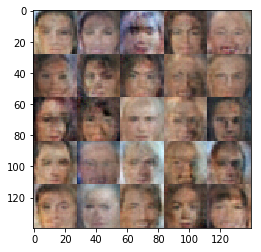

Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 2.6590
Epoch 1/1... Discriminator Loss: 0.2790... Generator Loss: 3.5475
Epoch 1/1... Discriminator Loss: 0.3077... Generator Loss: 2.1925
Epoch 1/1... Discriminator Loss: 0.5659... Generator Loss: 2.0395
Epoch 1/1... Discriminator Loss: 1.7009... Generator Loss: 0.4481
Epoch 1/1... Discriminator Loss: 0.8424... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 1.6503... Generator Loss: 0.2572
Epoch 1/1... Discriminator Loss: 0.3631... Generator Loss: 1.6586
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.6442


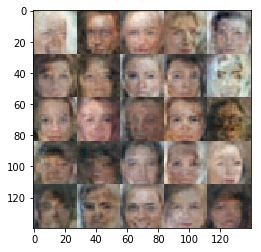

Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 0.6063
Epoch 1/1... Discriminator Loss: 0.7250... Generator Loss: 1.3289
Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 0.8013... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 0.2062... Generator Loss: 2.9045
Epoch 1/1... Discriminator Loss: 0.3890... Generator Loss: 1.4033
Epoch 1/1... Discriminator Loss: 2.2454... Generator Loss: 0.1423
Epoch 1/1... Discriminator Loss: 0.9411... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 0.7381... Generator Loss: 1.1963
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.5186


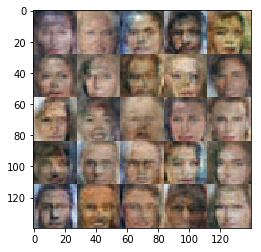

Epoch 1/1... Discriminator Loss: 0.2833... Generator Loss: 2.0730
Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 1.1695
Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 1.2458
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.3683
Epoch 1/1... Discriminator Loss: 0.7738... Generator Loss: 1.1279
Epoch 1/1... Discriminator Loss: 0.7485... Generator Loss: 1.1438
Epoch 1/1... Discriminator Loss: 0.8937... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.5737... Generator Loss: 0.3169
Epoch 1/1... Discriminator Loss: 0.2664... Generator Loss: 2.0787
Epoch 1/1... Discriminator Loss: 0.3646... Generator Loss: 1.5127


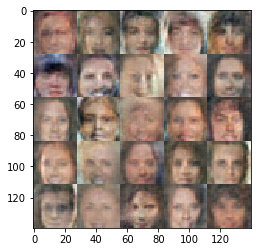

Epoch 1/1... Discriminator Loss: 0.1812... Generator Loss: 2.3275
Epoch 1/1... Discriminator Loss: 2.4073... Generator Loss: 3.3617
Epoch 1/1... Discriminator Loss: 0.5820... Generator Loss: 1.7557
Epoch 1/1... Discriminator Loss: 0.8290... Generator Loss: 1.2714
Epoch 1/1... Discriminator Loss: 0.5789... Generator Loss: 1.6987
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 0.5063... Generator Loss: 1.9913
Epoch 1/1... Discriminator Loss: 0.8910... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 2.2895... Generator Loss: 2.4761
Epoch 1/1... Discriminator Loss: 0.3559... Generator Loss: 1.4330


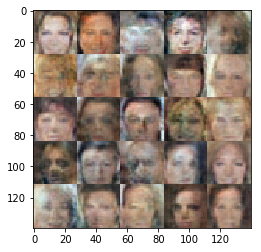

Epoch 1/1... Discriminator Loss: 0.4902... Generator Loss: 1.8669
Epoch 1/1... Discriminator Loss: 0.5099... Generator Loss: 1.5323
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.4343
Epoch 1/1... Discriminator Loss: 3.3825... Generator Loss: 3.9966
Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 0.6500... Generator Loss: 1.0299
Epoch 1/1... Discriminator Loss: 2.2494... Generator Loss: 3.2411
Epoch 1/1... Discriminator Loss: 1.6914... Generator Loss: 0.3335
Epoch 1/1... Discriminator Loss: 0.8968... Generator Loss: 1.1377
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 0.6456


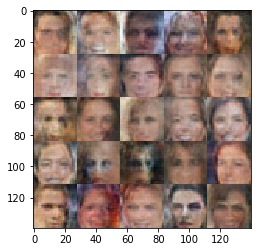

Epoch 1/1... Discriminator Loss: 0.2334... Generator Loss: 2.1579
Epoch 1/1... Discriminator Loss: 0.2196... Generator Loss: 2.5067
Epoch 1/1... Discriminator Loss: 0.3653... Generator Loss: 1.8075
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 2.8115
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.3849
Epoch 1/1... Discriminator Loss: 0.1820... Generator Loss: 2.4957
Epoch 1/1... Discriminator Loss: 0.7875... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 0.5273... Generator Loss: 1.0899
Epoch 1/1... Discriminator Loss: 0.1109... Generator Loss: 2.7840
Epoch 1/1... Discriminator Loss: 0.1933... Generator Loss: 3.2726


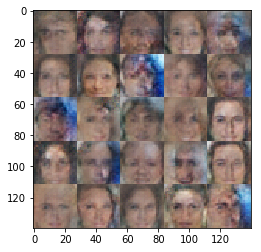

Epoch 1/1... Discriminator Loss: 0.1626... Generator Loss: 2.1778
Epoch 1/1... Discriminator Loss: 0.0651... Generator Loss: 8.4523
Epoch 1/1... Discriminator Loss: 0.7001... Generator Loss: 2.9712
Epoch 1/1... Discriminator Loss: 0.5615... Generator Loss: 2.0469
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 0.4825
Epoch 1/1... Discriminator Loss: 0.8505... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.9474... Generator Loss: 0.1983
Epoch 1/1... Discriminator Loss: 0.4810... Generator Loss: 1.2192
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.5102
Epoch 1/1... Discriminator Loss: 0.7355... Generator Loss: 1.1004


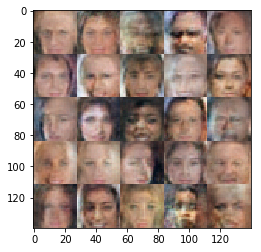

Epoch 1/1... Discriminator Loss: 0.7567... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 0.5801... Generator Loss: 1.8960
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.5026
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 3.3190
Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 1.6920
Epoch 1/1... Discriminator Loss: 0.6550... Generator Loss: 1.5242
Epoch 1/1... Discriminator Loss: 0.3906... Generator Loss: 1.5815
Epoch 1/1... Discriminator Loss: 1.5399... Generator Loss: 0.2989
Epoch 1/1... Discriminator Loss: 0.7731... Generator Loss: 0.8694


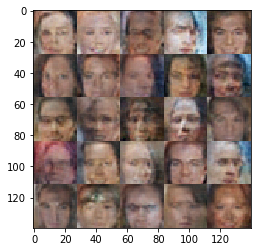

Epoch 1/1... Discriminator Loss: 0.3480... Generator Loss: 1.4703
Epoch 1/1... Discriminator Loss: 0.6564... Generator Loss: 1.5603
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 0.5131
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 0.9176
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.4653
Epoch 1/1... Discriminator Loss: 0.5391... Generator Loss: 2.5628
Epoch 1/1... Discriminator Loss: 0.8550... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 0.7574... Generator Loss: 0.8565


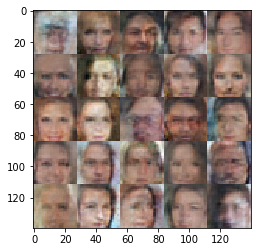

Epoch 1/1... Discriminator Loss: 1.5904... Generator Loss: 3.8148
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 2.6704
Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.7856... Generator Loss: 0.2547
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.4553
Epoch 1/1... Discriminator Loss: 0.6915... Generator Loss: 1.0861
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 0.5529
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 1.1256
Epoch 1/1... Discriminator Loss: 0.8769... Generator Loss: 0.8755
Epoch 1/1... Discriminator Loss: 0.7372... Generator Loss: 0.9882


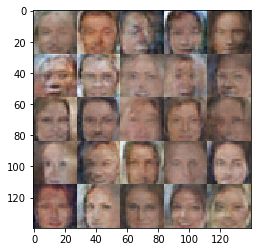

Epoch 1/1... Discriminator Loss: 0.3776... Generator Loss: 1.9088
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 1.3630
Epoch 1/1... Discriminator Loss: 0.5778... Generator Loss: 1.4765
Epoch 1/1... Discriminator Loss: 0.7894... Generator Loss: 3.3276
Epoch 1/1... Discriminator Loss: 0.8352... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 0.7783... Generator Loss: 1.5056
Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.4018
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 0.7048... Generator Loss: 1.0797
Epoch 1/1... Discriminator Loss: 1.6540... Generator Loss: 1.1301


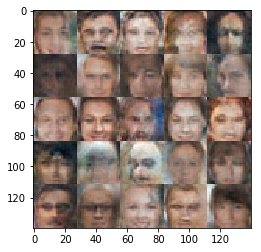

Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 1.7398
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.3878
Epoch 1/1... Discriminator Loss: 1.5379... Generator Loss: 0.3242
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 0.6507... Generator Loss: 0.9603
Epoch 1/1... Discriminator Loss: 0.7193... Generator Loss: 0.9854
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 0.4886
Epoch 1/1... Discriminator Loss: 1.9850... Generator Loss: 2.7422
Epoch 1/1... Discriminator Loss: 0.7705... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 0.5968


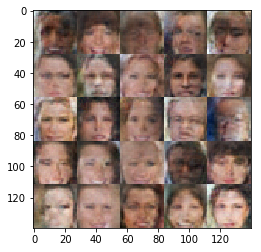

Epoch 1/1... Discriminator Loss: 0.7059... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 0.8686... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 0.6950... Generator Loss: 1.0700
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 1.8307
Epoch 1/1... Discriminator Loss: 0.7552... Generator Loss: 0.9267
Epoch 1/1... Discriminator Loss: 0.9559... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 0.6483... Generator Loss: 1.6057
Epoch 1/1... Discriminator Loss: 0.7067... Generator Loss: 2.3467


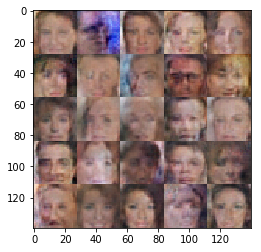

Epoch 1/1... Discriminator Loss: 0.3912... Generator Loss: 1.5377
Epoch 1/1... Discriminator Loss: 0.9758... Generator Loss: 0.9733
Epoch 1/1... Discriminator Loss: 0.8867... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 0.7757... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 2.0754
Epoch 1/1... Discriminator Loss: 0.8789... Generator Loss: 2.1547
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.7159... Generator Loss: 2.0307
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.4412
Epoch 1/1... Discriminator Loss: 0.5678... Generator Loss: 1.0600


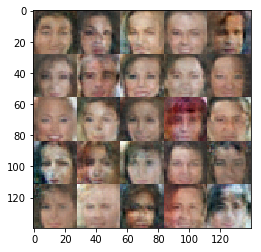

Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.3665
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 3.1275
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.3986
Epoch 1/1... Discriminator Loss: 0.9651... Generator Loss: 1.7802
Epoch 1/1... Discriminator Loss: 0.4959... Generator Loss: 2.8987
Epoch 1/1... Discriminator Loss: 0.5729... Generator Loss: 1.4125
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.4402
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 2.7869
Epoch 1/1... Discriminator Loss: 0.3238... Generator Loss: 1.7078
Epoch 1/1... Discriminator Loss: 0.4399... Generator Loss: 1.1756


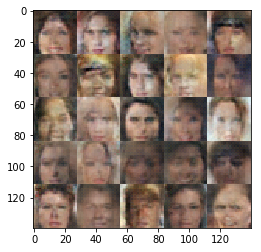

Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 1.0886
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.4038
Epoch 1/1... Discriminator Loss: 1.5673... Generator Loss: 0.3429
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.3372
Epoch 1/1... Discriminator Loss: 1.6891... Generator Loss: 0.2602
Epoch 1/1... Discriminator Loss: 0.4459... Generator Loss: 1.7838
Epoch 1/1... Discriminator Loss: 0.3098... Generator Loss: 1.7964
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.4960
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 3.1736
Epoch 1/1... Discriminator Loss: 0.5163... Generator Loss: 1.5534


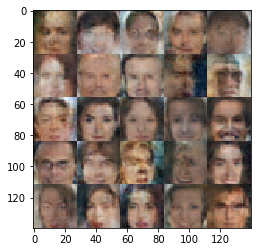

Epoch 1/1... Discriminator Loss: 0.7870... Generator Loss: 2.2384
Epoch 1/1... Discriminator Loss: 0.8423... Generator Loss: 1.0453
Epoch 1/1... Discriminator Loss: 0.6427... Generator Loss: 1.3679
Epoch 1/1... Discriminator Loss: 0.7462... Generator Loss: 1.8119
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 1.3794
Epoch 1/1... Discriminator Loss: 0.2164... Generator Loss: 1.9600
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.4513
Epoch 1/1... Discriminator Loss: 0.8437... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.4223
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.5368


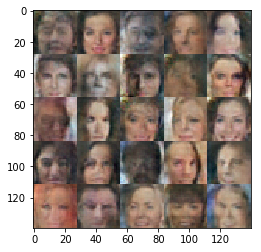

Epoch 1/1... Discriminator Loss: 3.6094... Generator Loss: 3.8880
Epoch 1/1... Discriminator Loss: 0.3375... Generator Loss: 2.3410
Epoch 1/1... Discriminator Loss: 0.5002... Generator Loss: 1.7374
Epoch 1/1... Discriminator Loss: 0.5724... Generator Loss: 0.9679
Epoch 1/1... Discriminator Loss: 1.6929... Generator Loss: 0.5146
Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 0.5271
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.3856
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 2.9319
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.3580


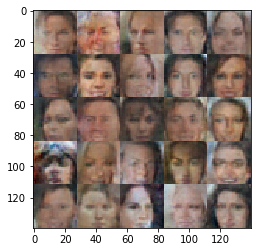

Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.3497
Epoch 1/1... Discriminator Loss: 0.7728... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.3783
Epoch 1/1... Discriminator Loss: 1.8140... Generator Loss: 2.6819
Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 1.5600
Epoch 1/1... Discriminator Loss: 0.3583... Generator Loss: 1.8107
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.3803
Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.3592
Epoch 1/1... Discriminator Loss: 0.9543... Generator Loss: 0.6597


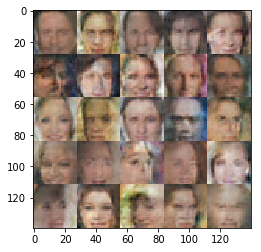

Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.3957
Epoch 1/1... Discriminator Loss: 0.5349... Generator Loss: 1.3330
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.3389
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 0.3994... Generator Loss: 1.5152
Epoch 1/1... Discriminator Loss: 1.5743... Generator Loss: 2.8027
Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 0.5722
Epoch 1/1... Discriminator Loss: 0.4394... Generator Loss: 1.3746
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.4594
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 0.7764


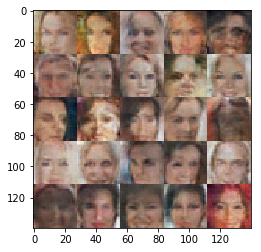

Epoch 1/1... Discriminator Loss: 0.6640... Generator Loss: 1.4054
Epoch 1/1... Discriminator Loss: 2.0129... Generator Loss: 0.1758
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.3390
Epoch 1/1... Discriminator Loss: 0.6969... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.3909
Epoch 1/1... Discriminator Loss: 0.9508... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 1.1006
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 1.5448


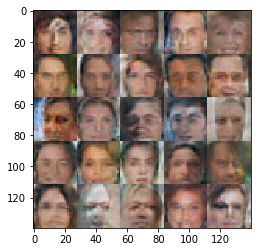

Epoch 1/1... Discriminator Loss: 1.7043... Generator Loss: 0.2513
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 1.2669
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 2.2258
Epoch 1/1... Discriminator Loss: 0.7839... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 0.5822
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.3757
Epoch 1/1... Discriminator Loss: 0.6007... Generator Loss: 2.0767
Epoch 1/1... Discriminator Loss: 0.7722... Generator Loss: 1.2758
Epoch 1/1... Discriminator Loss: 1.7077... Generator Loss: 2.5202
Epoch 1/1... Discriminator Loss: 0.7249... Generator Loss: 2.4539


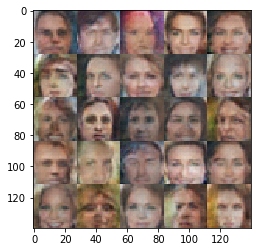

Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 1.0976
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 2.0086
Epoch 1/1... Discriminator Loss: 1.5835... Generator Loss: 0.3280
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 0.5459
Epoch 1/1... Discriminator Loss: 0.7535... Generator Loss: 3.2734
Epoch 1/1... Discriminator Loss: 3.4447... Generator Loss: 3.2891
Epoch 1/1... Discriminator Loss: 0.6091... Generator Loss: 2.0304
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.3729
Epoch 1/1... Discriminator Loss: 1.5612... Generator Loss: 2.3603
Epoch 1/1... Discriminator Loss: 0.8841... Generator Loss: 1.1505


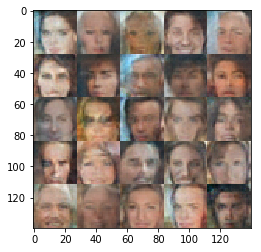

Epoch 1/1... Discriminator Loss: 2.3208... Generator Loss: 0.1368
Epoch 1/1... Discriminator Loss: 1.0185... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 1.5578
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.4187
Epoch 1/1... Discriminator Loss: 0.7635... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 0.9384... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 0.9232... Generator Loss: 1.1458
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.3664
Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 0.8649


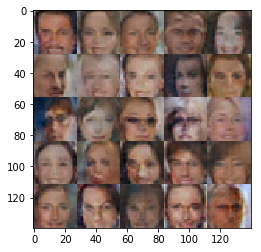

Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.0383
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.5319
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.9011... Generator Loss: 0.1944
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.4020
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 1.2215
Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 0.6813


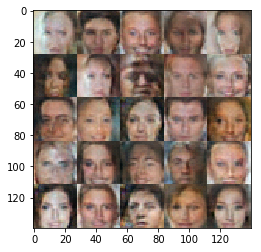

Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 0.6173... Generator Loss: 1.2087
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.4690
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.4179
Epoch 1/1... Discriminator Loss: 0.2311... Generator Loss: 1.9180
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 1.8400
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.5623
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 0.7429


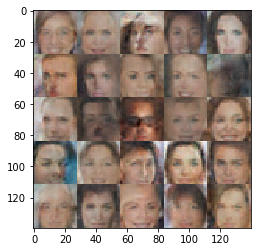

Epoch 1/1... Discriminator Loss: 0.5445... Generator Loss: 1.3564
Epoch 1/1... Discriminator Loss: 2.1627... Generator Loss: 0.1424
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.7357


In [455]:
batch_size = 32
z_dim = 100
learning_rate = 0.00061
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.